/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Gradients shape: torch.Size([1, 197, 768])
Activations shape: torch.Size([1, 197, 768])
Error in generate_cam: mat1 and mat2 shapes cannot be multiplied (1x197 and 1x197)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


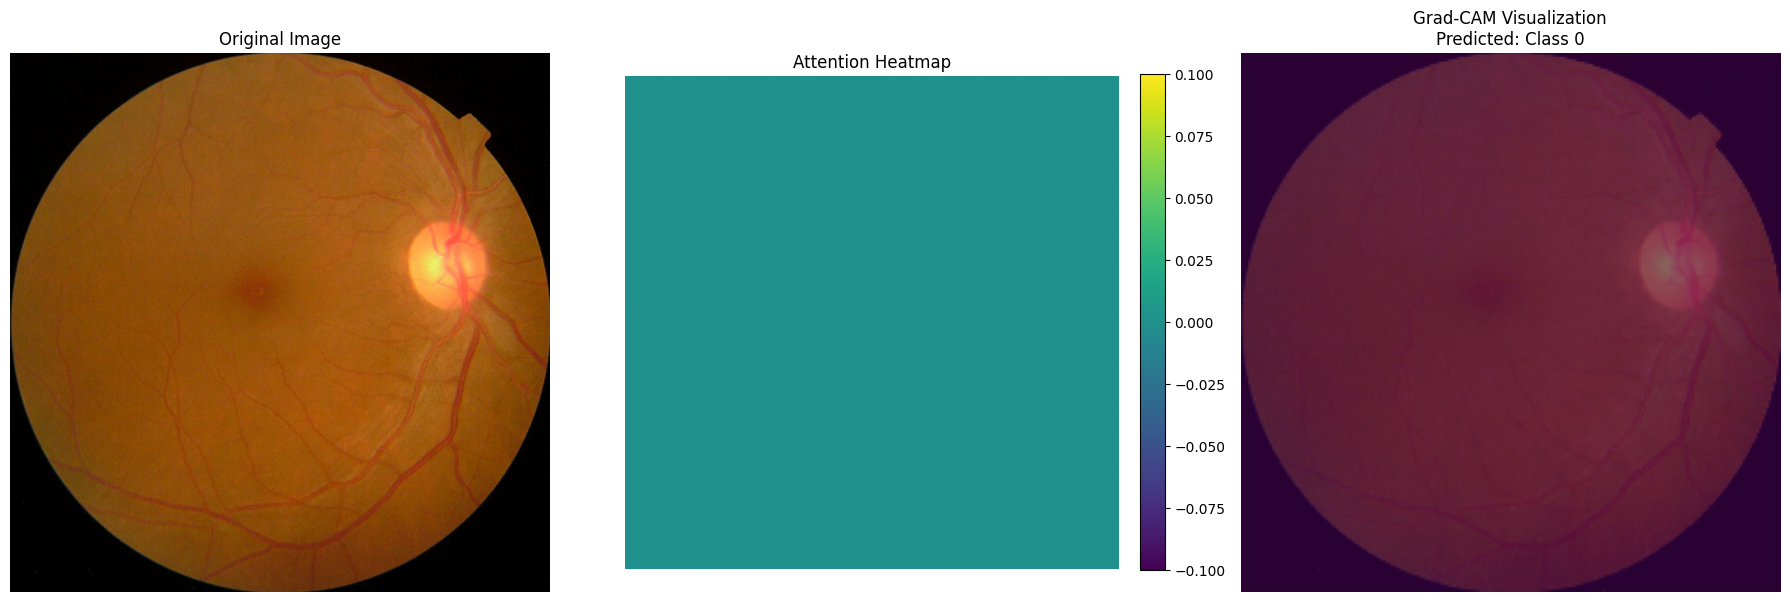

In [20]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import math

class GradCAM:
    def __init__(self, model):
        self.model = model.model
        self.target_layer = self.model.vit.encoder.layer[-1].attention
        self.model.eval()
        
        self.gradients = []
        self.activations = []
        
        def save_gradient(module, grad_input, grad_output):
            self.gradients.append(grad_output[0].detach())
            
        def save_activation(module, input, output):
            self.activations.append(output[0].detach())
            
        self.target_layer.register_forward_hook(save_activation)
        self.target_layer.register_full_backward_hook(save_gradient)

    def generate_cam(self, input_image, target_class=None):
        self.gradients = []
        self.activations = []
        
        image_tensor = input_image.unsqueeze(0).to(self.model.device)
        
        # Forward pass
        output = self.model(image_tensor).logits
        pred_class = output.argmax(dim=1).item() if target_class is None else target_class
        
        # Clear gradients
        self.model.zero_grad()
        
        # Backward pass
        class_loss = output[0, pred_class]
        class_loss.backward()
        
        try:
            # Get gradients and activations
            gradients = self.gradients[0]  # [seq_len, seq_len, dim]
            activations = self.activations[0]  # [seq_len, seq_len, dim]
            
            # Print shapes for debugging
            print(f"Gradients shape: {gradients.shape}")
            print(f"Activations shape: {activations.shape}")
            
            # Average over the feature dimension
            if len(gradients.shape) == 3:
                weights = torch.mean(gradients, dim=2)  # Explicit dimension
            else:
                weights = gradients
                
            if len(activations.shape) == 3:
                acts = torch.mean(activations, dim=2)  # Explicit dimension
            else:
                acts = activations
            
            # Calculate attention scores
            cam = torch.matmul(weights, acts)
            
            # Ensure we have a 2D tensor
            if len(cam.shape) > 2:
                cam = torch.mean(cam, dim=0)
            
            # Handle potential empty or invalid tensors
            if torch.numel(cam) == 0:
                print("Warning: Empty tensor encountered")
                return np.zeros((input_image.shape[1], input_image.shape[2])), pred_class
                
            # Normalize the cam
            cam = cam - torch.min(cam)
            cam_max = torch.max(cam)
            if cam_max != 0:
                cam = cam / cam_max
            
            # Convert to numpy and resize
            cam = cam.cpu().numpy()
            
            # Ensure proper shape for resize
            if len(cam.shape) == 1:
                size = int(np.sqrt(cam.shape[0]))
                cam = cam.reshape(size, size)
            
            cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[1]))
            
            return cam, pred_class
            
        except Exception as e:
            print(f"Error in generate_cam: {str(e)}")
            # Return a default heatmap in case of error
            return np.zeros((input_image.shape[1], input_image.shape[2])), pred_class

class RetinalExplainer:
    def __init__(self, classifier_model):
        self.grad_cam = GradCAM(classifier_model)
        self.model = classifier_model
        
    def explain(self, image_path, save_path=None, alpha=0.6):
        """
        Generate and optionally save explanation visualization
        """
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        preprocess = self.model.transform
        input_tensor = preprocess(image).to(self.model.model.device)
        
        # Generate CAM
        cam, pred_class = self.grad_cam.generate_cam(input_tensor)
        
        # Enhance contrast of the CAM
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-7)
        
        # Apply gamma correction for better visualization
        gamma = 0.5
        cam = np.power(cam, gamma)
        
        # Create heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_VIRIDIS)
        
        # Load original image and resize to match heatmap
        original_image = cv2.imread(image_path)
        original_image = cv2.resize(original_image, (cam.shape[1], cam.shape[0]))
        
        # Superimpose heatmap on original image
        superimposed_img = cv2.addWeighted(original_image, 1-alpha, heatmap, alpha, 0)
        
        if save_path:
            cv2.imwrite(save_path, superimposed_img)
            
        return superimposed_img, pred_class, cam

    def plot_explanation(self, image_path, class_names=None):
        """
        Plot the original image, attention heatmap, and superimposed visualization
        """
        # Generate explanation
        superimposed_img, pred_class, cam = self.explain(image_path)
        
        # Load original image
        original_image = cv2.imread(image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        
        # Create figure with subplots
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # Plot original image
        ax1.imshow(original_image)
        ax1.set_title('Original Image')
        ax1.axis('off')
        
        # Plot attention heatmap
        im2 = ax2.imshow(cam, cmap='viridis')
        ax2.set_title('Attention Heatmap')
        ax2.axis('off')
        plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
        
        # Plot superimposed visualization
        ax3.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        class_label = class_names[pred_class] if class_names else f'Class {pred_class}'
        ax3.set_title(f'Grad-CAM Visualization\nPredicted: {class_label}')
        ax3.axis('off')
        
        plt.tight_layout()
        return fig

import torch.nn as nn
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torchvision import transforms
    

class RetinalClassifier:
    def __init__(self, num_classes=5):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224',
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        ).to(self.device)
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    def train(self, train_loader, num_epochs=10):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-5)
        
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(inputs).logits
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            epoch_loss = running_loss/len(train_loader)
            epoch_accuracy = 100 * correct / total
            print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    def predict(self, image_path):
        self.model.eval()
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(image).logits
            _, predicted = torch.max(outputs, 1)
            
        return predicted.item()


# Usage example
if __name__ == "__main__":
    # Assuming we have a trained classifier

    model = RetinalClassifier()
    
    # Load the saved dictionary
    checkpoint = torch.load('best_model.pth')
    
    # Load the state dictionary into the model
    model.model.load_state_dict(checkpoint['model_state_dict'])
    model.model.eval()  # Set to evaluation mode
    
    # Create explainer with loaded model
    explainer = RetinalExplainer(model)
    
    # Generate and display explanation for a sample image
    fig = explainer.plot_explanation('/Users/devshah/Documents/WorkSpace/University/year 3/CSC490/Zero-Shot-Object-Tracking-FPS/APTOS 2019 Blindness Detection/train_images/0a4e1a29ffff.png')
    plt.show()